# Table of Contents

# 1. Introduction

In [136]:
!pip install sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# For display in notebook
from IPython.display import display


# 2. Data Loading and Preprocessing

In [138]:
df = pd.read_csv("raw_data.csv")
print("Data loaded. Shape:", df.shape)
df.head()

Data loaded. Shape: (74, 12)


,prompt_id,prompt,model_name,iteration_no,average_token_count,min_max_token_variance_%,average_tps,average_inference_time,sample_output,isCorrect,prompt_type,base_question
0,4651ffa4-7782-405a-bc59-b975cb9aea67,How many r's are in the word strawberry?,deepseek-r1:1.5b,10,178.7,47.081712,53.166395,3.361146,<think> I need to determine how many times the...,1.0,Zero-Shot,Strawberry
1,bef53a95-5ffb-4464-8d1e-e59023e5ac4d,How many r's are in the word strawberry?,deepseek-r1:1.5b,10,180.9,67.346939,55.004890,3.288798,<think> To determine how many times the letter...,0.0,NaN,Strawberry
2,871b3db4-ee84-409c-9695-8c893f0ca641,How many r's are in the word strawberry?,deepseek-r1:7b,10,251.2,84.832905,16.011677,15.688550,"<think> Alright, so I need to figure out how m...",0.0,Zero-Shot,Strawberry
3,9f1e1314-1aa3-48db-8a73-f8b2825254a6,How many r's are in the word strawberry?,deepseek-r1:7b,10,301.4,88.957597,15.625985,19.288384,<think> To determine how many times the letter...,0.0,Zero-Shot,Strawberry
4,8c184f47-b203-4759-90b3-1150761ee924,How many r's are in the word strawberry?,deepseek-r1:7b,10,296.3,85.940410,16.213668,18.274705,"<think> Okay, so I need to figure out how many...",1.0,Zero-Shot,Strawberry


In [139]:
def classify_prompt(prompt):
    prompt_lower = prompt.strip().lower()
    if "strawberry" in prompt_lower:
        return "Strawberry"
    elif "prime factorization" in prompt_lower or "factorization" in prompt_lower:
        return "Factorization"
    # Ensure both singular and plural forms are caught:
    elif "snake" in prompt_lower or "snakes" in prompt_lower or "pygame" in prompt_lower:
        return "Snakes"
    else:
        return "Unknown"


In [140]:
unique_models = df["model_name"].unique()
unique_questions = df["base_question"].unique()

print("Unique models:", unique_models)
print("Unique base_question types:", unique_questions)

# For example, let's group by base_question, then by model
grouped = df.groupby(["base_question", "model_name"])
summary_df = grouped.agg(
    sample_count=("prompt_id", "count"),
    avg_inference_time=("average_inference_time", "mean"),
    avg_token_count=("average_token_count", "mean"),
    accuracy_rate=("isCorrect", "mean"),
    avg_tps=("average_tps", "mean")
).reset_index()

# Convert accuracy rate to percentage
summary_df["accuracy_rate"] = summary_df["accuracy_rate"] * 100

print("Summary Stats by base_question and model_name:")
display(summary_df)


# Here you can see, for each (Question, Model) pair, the basic performance stats like average inference time, accuracy rate, etc.

Unique models: ['deepseek-r1:1.5b' 'deepseek-r1:7b' 'deepseek-r1:8b' 'qwen2.5:1.5b'
 'qwen2.5:3b' 'qwen2.5:7b' 'llama3.1' 'llama3.2']
Unique base_question types: ['Strawberry' 'Factorization' 'Snakes' nan]
Summary Stats by base_question and model_name:


,base_question,model_name,sample_count,avg_inference_time,avg_token_count,accuracy_rate,avg_tps
0,Factorization,deepseek-r1:1.5b,2,29.810381,1128.266667,50.000000,38.013188
1,Factorization,deepseek-r1:7b,3,62.259572,843.444444,33.333333,13.135316
2,Factorization,deepseek-r1:8b,2,21.717045,265.666667,100.000000,12.216122
3,Factorization,qwen2.5:1.5b,2,23.421956,302.300000,0.000000,12.890589
4,Factorization,qwen2.5:3b,3,57.699437,365.866667,0.000000,6.327857
5,Factorization,qwen2.5:7b,2,118.272265,357.950000,100.000000,3.027486
6,Snakes,deepseek-r1:1.5b,2,72.977897,3728.333333,0.000000,49.097862
7,Snakes,deepseek-r1:7b,3,79.818068,1191.666667,50.000000,14.907652
8,Snakes,deepseek-r1:8b,3,74.564871,1082.111111,100.000000,14.462425
9,Strawberry,deepseek-r1:1.5b,7,4.986601,267.871429,28.571429,53.377349


In [141]:
print(df["prompt"].unique())
print(df[df["prompt"].str.contains("snake", case=False)].head())


["How many r's are in the word strawberry?"
 'You are a large language model acting as an expert assistant in verbal reasoning. Answer the question: "How many r\'s are in the word \'strawberry\'?"'
 'Please show your step-by-step reasoning (a full chain-of-thought process). The question to answer is: “How many r’s are in the word ‘strawberry?'
 'What is the prime factorization of 9,999?'
 'You are a professor of mathematics at a prestigious university and then provide your succinct final result as to the question: What is the prime factorization of 9,999?'
 'Please demonstrate your detailed, step-by-step solution as “Chain of Thought” and then provide your answer to the question: What is the prime factorization of 9,999?'
 'Create a Snake game in Python using Pygame'
 'You are an expert game developer. The user wants a Snake game in Python using Pygame with these features: Provide your final working cod, along with any relevant explanation of how you structured the code.'
 'You are an 

In [142]:
print(df[df["base_question"] == "Snakes"].groupby("model_name")["prompt_id"].count())

model_name
deepseek-r1:1.5b    2
deepseek-r1:7b      3
deepseek-r1:8b      3
Name: prompt_id, dtype: int64


In [143]:
# ## 4. Prompt Engineering Analysis
# 
# For instance, check how `prompt_type` (e.g. "zero-shot", "chain-of-thought", "role-based") correlates with accuracy or other metrics.

prompt_type_grouped = df.groupby(["base_question", "prompt_type"]).agg(
    count=("prompt_id", "count"),
    avg_accuracy=("isCorrect", "mean"),
    avg_inference_time=("average_inference_time", "mean")
).reset_index()

# Convert to percentage
prompt_type_grouped["avg_accuracy"] = prompt_type_grouped["avg_accuracy"] * 100

print("Analysis of prompt_type within each base_question:")
display(prompt_type_grouped)

Analysis of prompt_type within each base_question:


,base_question,prompt_type,count,avg_accuracy,avg_inference_time
0,Factorization,COT,4,25.000000,44.219349
1,Factorization,Role Based,5,40.000000,55.903503
2,Factorization,Zero-Shot,5,60.000000,57.985081
3,Snakes,COT,2,NaN,86.647289
4,Snakes,Role Based,3,66.666667,89.234916
5,Snakes,Zero-Shot,3,33.333333,56.035095
6,Strawberry,COT,6,50.000000,18.266791
7,Strawberry,Role Based,11,54.545455,17.144015
8,Strawberry,Zero-Shot,8,50.000000,11.051387


In [144]:
# ## 5. Filtering and Embedding Analysis
# 
# Next, we can **embed** the outputs. We'll do it for each **(model, base_question)** subset to see how consistent the embeddings are. 
# 
# **Note**: If you already have many rows, embedding them all can be time-consuming. Consider filtering or sampling.

# %%
# 5.1: For demonstration, let's define a function that:
#  - Filters the DataFrame for a single (model, base_question) pair
#  - Generates embeddings with SentenceTransformer
#  - Computes average intra-group similarity
#  - Optional: produces a PCA or t-SNE plot

def analyze_embeddings_for_subset(df, model_name, question_label, embedder):
    """
    Embeds the sample_output for the specified model and base_question,
    computes average similarity, and returns a small summary DataFrame
    along with the embeddings themselves.
    """
    subset = df[(df["model_name"] == model_name) & (df["base_question"] == question_label)]
    
    if subset.empty:
        print(f"No rows for model={model_name}, base_question={question_label}")
        return None, None
    
    # Convert to list
    texts = subset["sample_output"].fillna("").tolist()
    
    # Generate embeddings
    embeddings = embedder.encode(texts, batch_size=16, show_progress_bar=False)
    
    # Compute pairwise cosine similarity
    cos_sim = cosine_similarity(embeddings)
    
    # Average similarity (upper triangle)
    if len(subset) > 1:
        triu_indices = np.triu_indices_from(cos_sim, k=1)
        avg_sim = np.mean(cos_sim[triu_indices])
    else:
        avg_sim = np.nan
    
    # Create a mini summary
    mini_summary = pd.DataFrame({
        "model": [model_name],
        "base_question": [question_label],
        "sample_count": [len(subset)],
        "average_inference_time": [subset["average_inference_time"].mean()],
        "accuracy_rate": [subset["isCorrect"].mean() * 100],
        "avg_embedding_similarity": [avg_sim]
    })
    
    return mini_summary, embeddings


# 5.2: Initialize the embedding model once
embed_model_name = "all-MiniLM-L6-v2"
print(f"Loading SentenceTransformer({embed_model_name})...")
embedder = SentenceTransformer(embed_model_name)

# 5.3: Iterate over each (model, base_question) pair, run embedding analysis, and collect results
all_embed_results = []
for model in unique_models:
    for question_label in unique_questions:
        mini_summary, embeddings = analyze_embeddings_for_subset(df, model, question_label, embedder)
        if mini_summary is not None:
            all_embed_results.append(mini_summary)

# Combine all mini summaries
if all_embed_results:
    embed_results_df = pd.concat(all_embed_results, ignore_index=True)
    display(embed_results_df)
else:
    print("No embedding results generated.")

Loading SentenceTransformer(all-MiniLM-L6-v2)...
No rows for model=deepseek-r1:1.5b, base_question=nan
No rows for model=deepseek-r1:7b, base_question=nan
No rows for model=deepseek-r1:8b, base_question=nan
No rows for model=qwen2.5:1.5b, base_question=Snakes
No rows for model=qwen2.5:1.5b, base_question=nan
No rows for model=qwen2.5:3b, base_question=Snakes
No rows for model=qwen2.5:3b, base_question=nan
No rows for model=qwen2.5:7b, base_question=Strawberry
No rows for model=qwen2.5:7b, base_question=Snakes
No rows for model=qwen2.5:7b, base_question=nan
No rows for model=llama3.1, base_question=Strawberry
No rows for model=llama3.1, base_question=Factorization
No rows for model=llama3.1, base_question=Snakes
No rows for model=llama3.1, base_question=nan
No rows for model=llama3.2, base_question=Strawberry
No rows for model=llama3.2, base_question=Factorization
No rows for model=llama3.2, base_question=Snakes
No rows for model=llama3.2, base_question=nan


,model,base_question,sample_count,average_inference_time,accuracy_rate,avg_embedding_similarity
0,deepseek-r1:1.5b,Strawberry,7,4.986601,28.571429,0.808556
1,deepseek-r1:1.5b,Factorization,2,29.810381,50.000000,0.853860
2,deepseek-r1:1.5b,Snakes,2,72.977897,0.000000,0.891591
3,deepseek-r1:7b,Strawberry,5,29.594645,60.000000,0.864556
4,deepseek-r1:7b,Factorization,3,62.259572,33.333333,0.885663
5,deepseek-r1:7b,Snakes,3,79.818068,50.000000,0.822759
6,deepseek-r1:8b,Strawberry,6,22.385410,100.000000,0.868600
7,deepseek-r1:8b,Factorization,2,21.717045,100.000000,0.932233
8,deepseek-r1:8b,Snakes,3,74.564871,100.000000,0.897880
9,qwen2.5:1.5b,Strawberry,3,4.417540,33.333333,0.784213


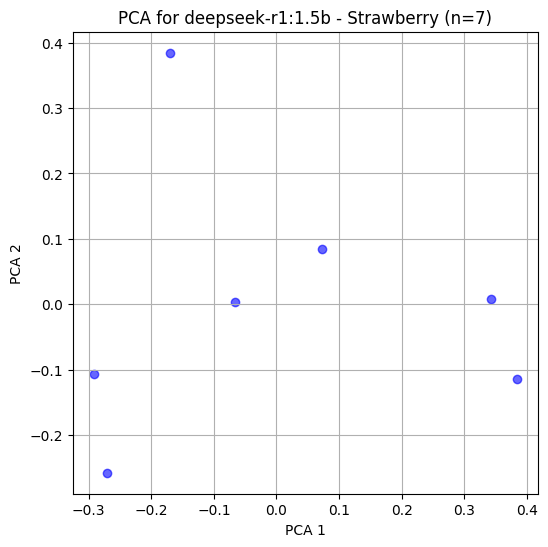

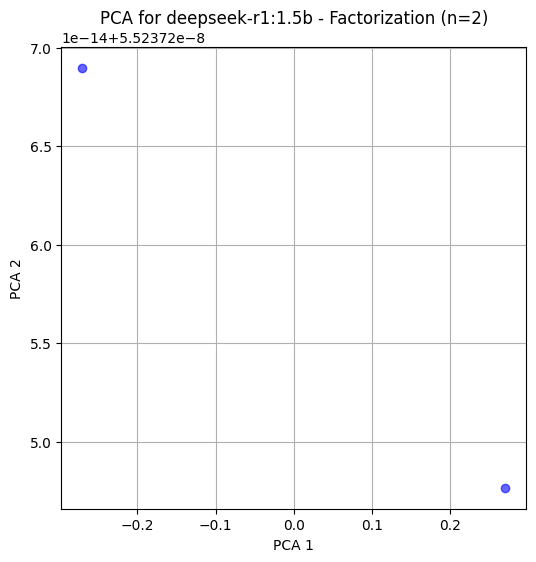

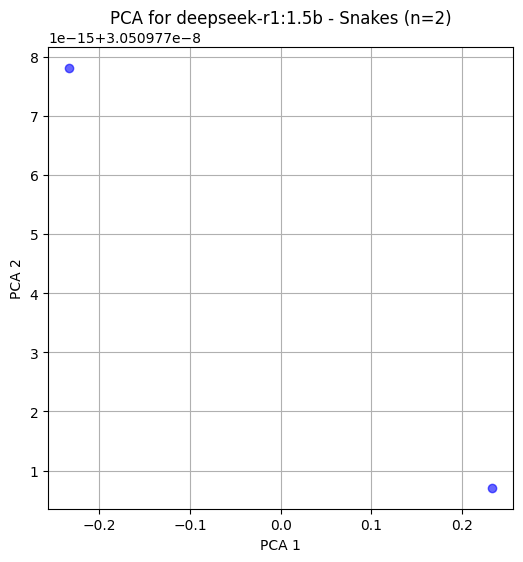

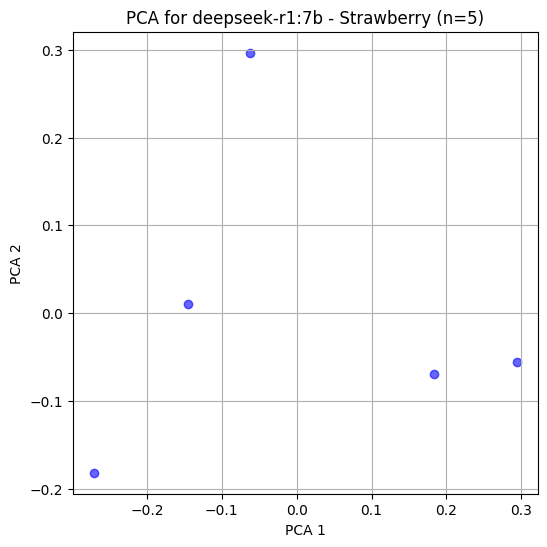

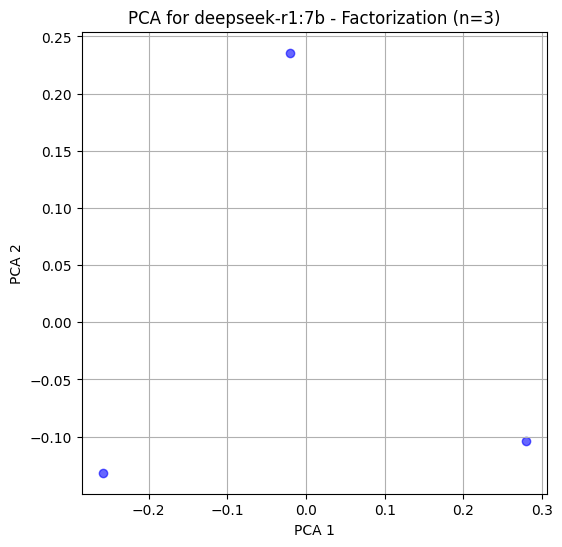

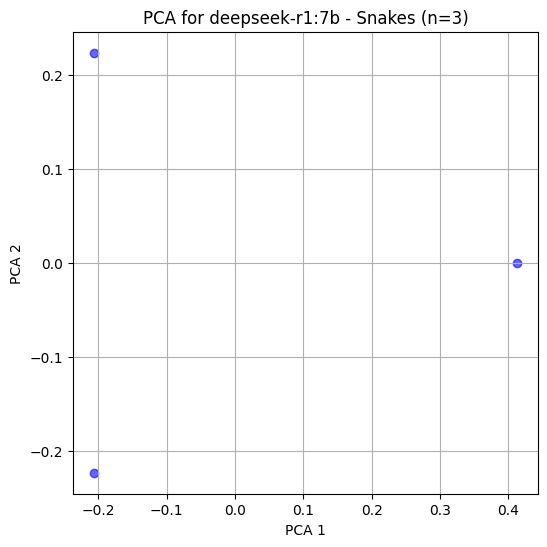

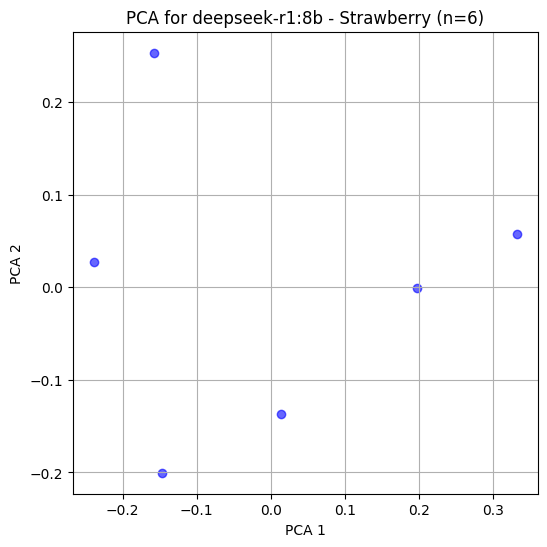

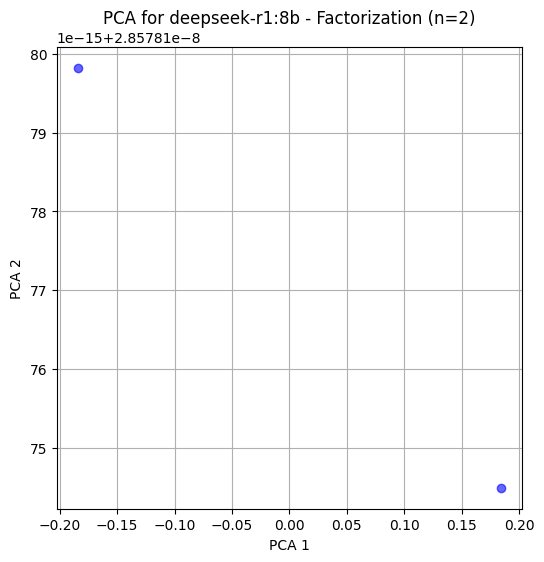

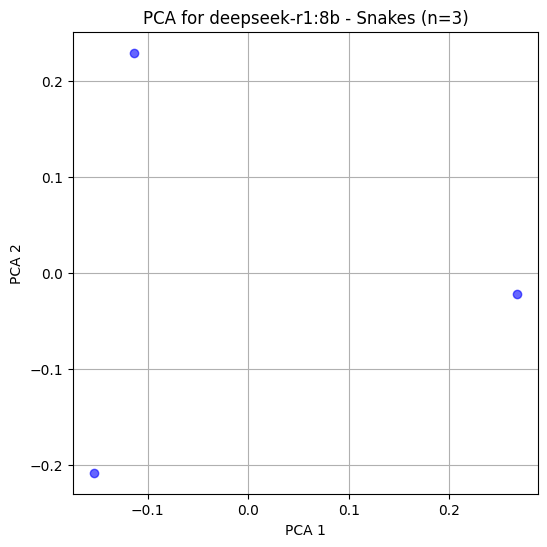

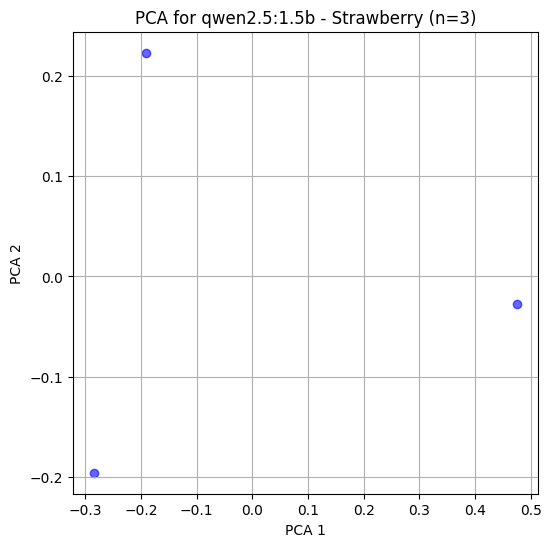

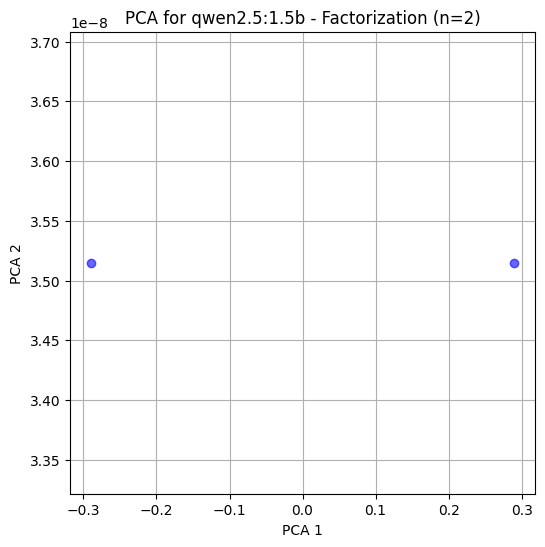

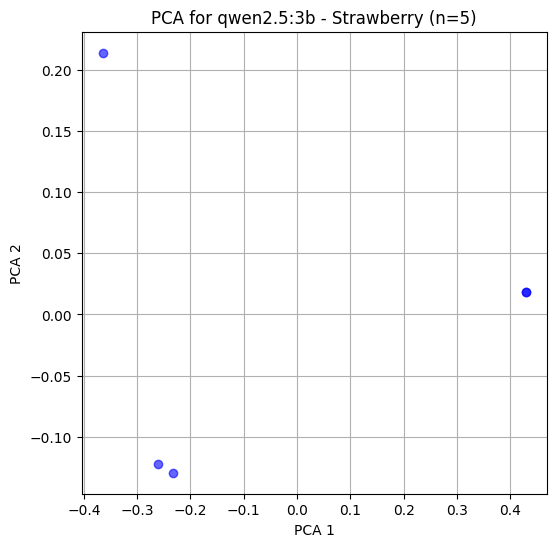

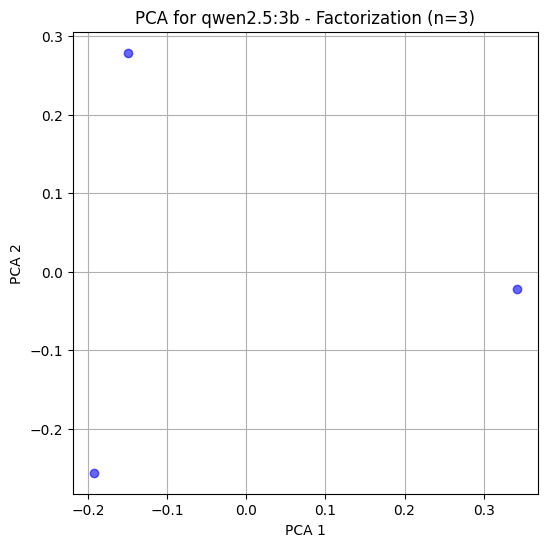

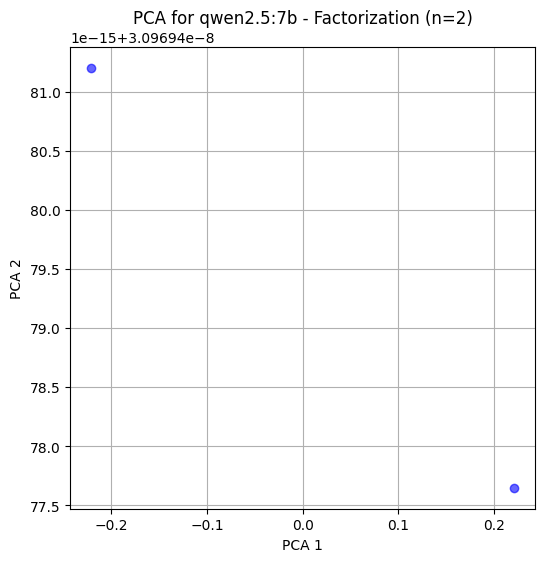

In [145]:
# ## 6. Optional: Visualize PCA / t-SNE for (model, question) Subsets
# 
# You can further produce **subset-level** PCA or t-SNE scatter plots. For example:

# %%
def plot_pca_for_subset(embeddings, subset_df, model_name, question_label):
    """
    Perform PCA on the subset embeddings, then plot.
    """
    if embeddings is None or len(embeddings) < 2:
        print(f"Not enough samples for a PCA plot (model={model_name}, base_question={question_label}).")
        return
    
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(6, 6))
    plt.scatter(pca_coords[:,0], pca_coords[:,1], c="blue", alpha=0.6)
    
    plt.title(f"PCA for {model_name} - {question_label} (n={len(embeddings)})")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()

# Example usage: generate PCA for each (model, question)
for model in unique_models:
    for question_label in unique_questions:
        subset = df[(df["model_name"] == model) & (df["base_question"] == question_label)]
        if not subset.empty:
            texts = subset["sample_output"].fillna("").tolist()
            if len(texts) > 1:
                emb = embedder.encode(texts, batch_size=16, show_progress_bar=False)
                plot_pca_for_subset(emb, subset, model, question_label)


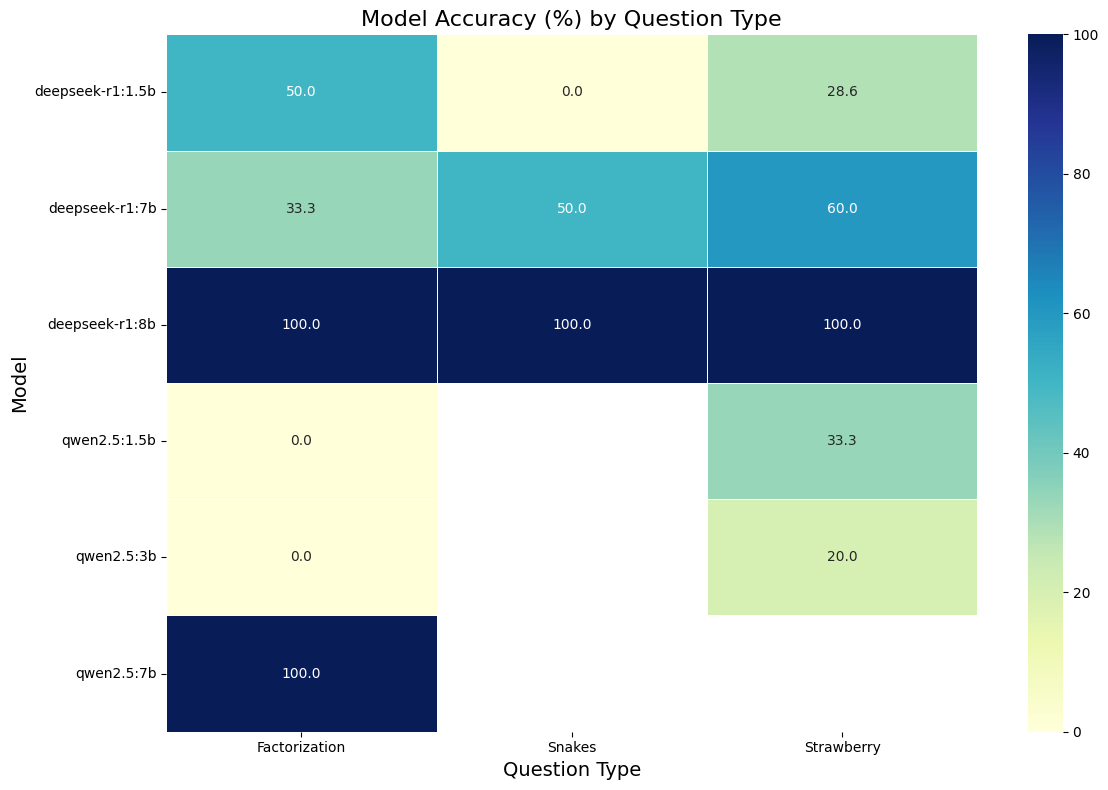

In [146]:
# 7.1 Model Performance Comparison
plt.figure(figsize=(12, 8))
model_performance = summary_df.pivot(index="model_name", columns="base_question", values="accuracy_rate")
sns.heatmap(model_performance, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=.5)
plt.title("Model Accuracy (%) by Question Type", fontsize=16)
plt.ylabel("Model", fontsize=14)
plt.xlabel("Question Type", fontsize=14)
plt.tight_layout()
plt.show()

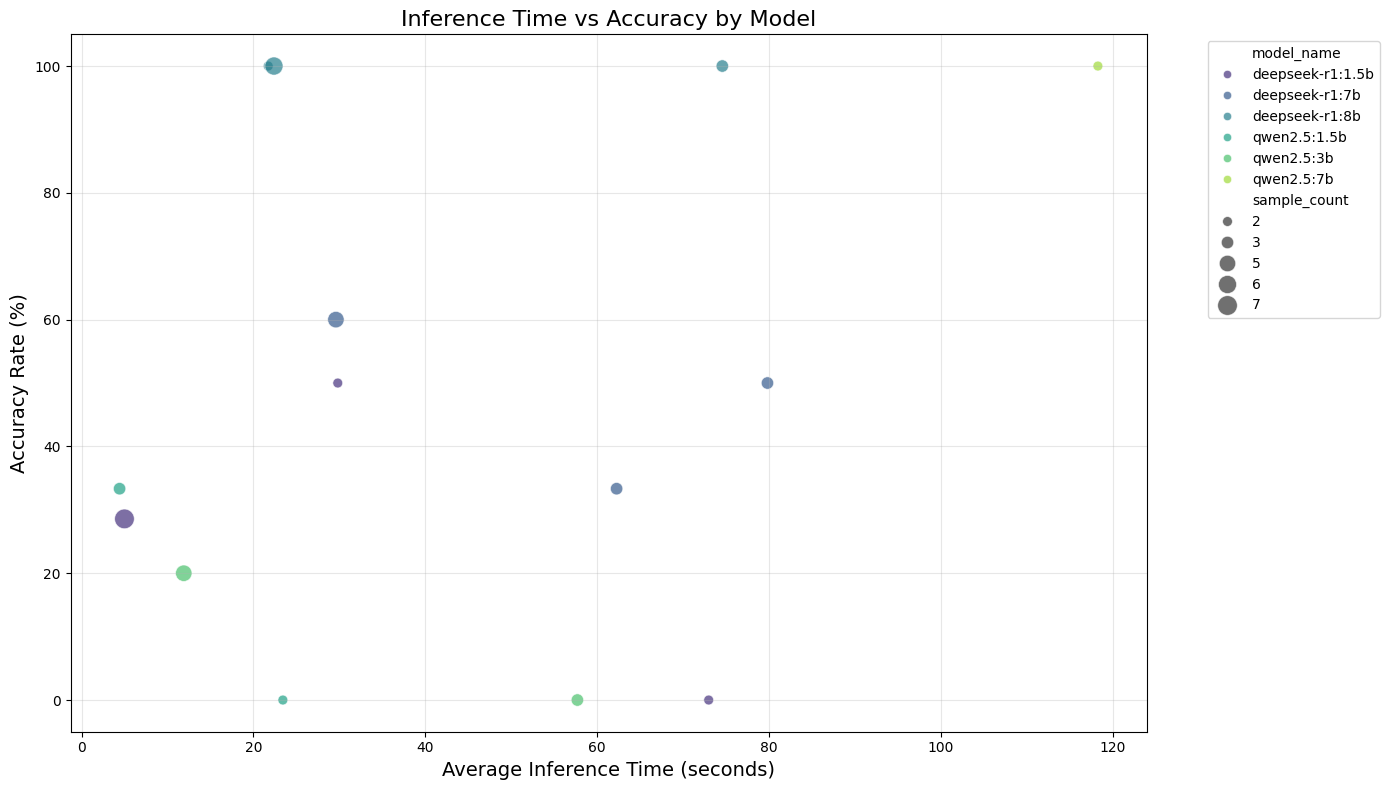

In [147]:
# 7.2 Inference Time vs Accuracy Scatter Plot
plt.figure(figsize=(14, 8))
sns.scatterplot(data=summary_df, x="avg_inference_time", y="accuracy_rate", 
                hue="model_name", size="sample_count", sizes=(50, 200),
                alpha=0.7, palette="viridis")
plt.title("Inference Time vs Accuracy by Model", fontsize=16)
plt.xlabel("Average Inference Time (seconds)", fontsize=14)
plt.ylabel("Accuracy Rate (%)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

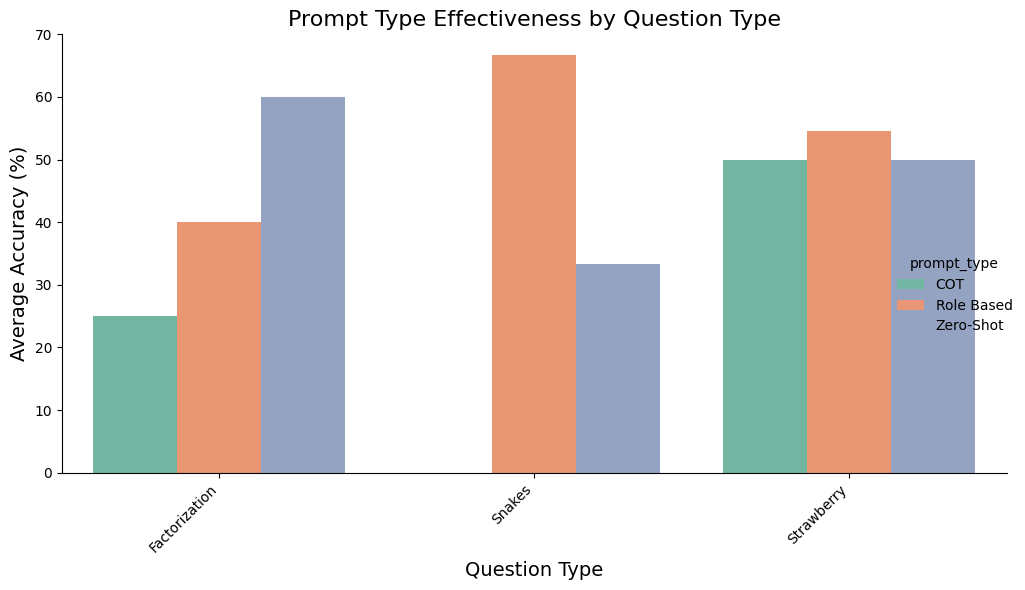

In [148]:
# 7.3 Prompt Type Effectiveness
plt.figure(figsize=(14, 8))
g = sns.catplot(data=prompt_type_grouped, x="base_question", y="avg_accuracy", 
                hue="prompt_type", kind="bar", height=6, aspect=1.5, palette="Set2")
g.set_xticklabels(rotation=45, ha="right")
plt.title("Prompt Type Effectiveness by Question Type", fontsize=16)
plt.xlabel("Question Type", fontsize=14)
plt.ylabel("Average Accuracy (%)", fontsize=14)
plt.tight_layout()
plt.show()

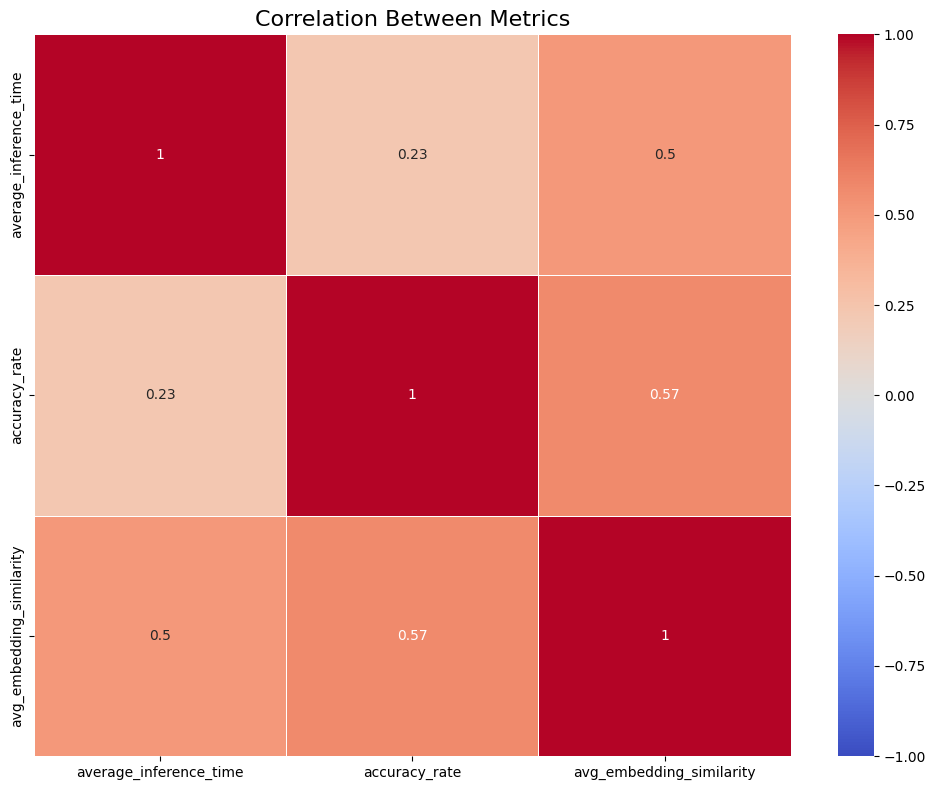

/var/folders/8p/3y0vt8nx0j77_stq2p7d95t80000gn/T/ipykernel_18241/2734307863.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




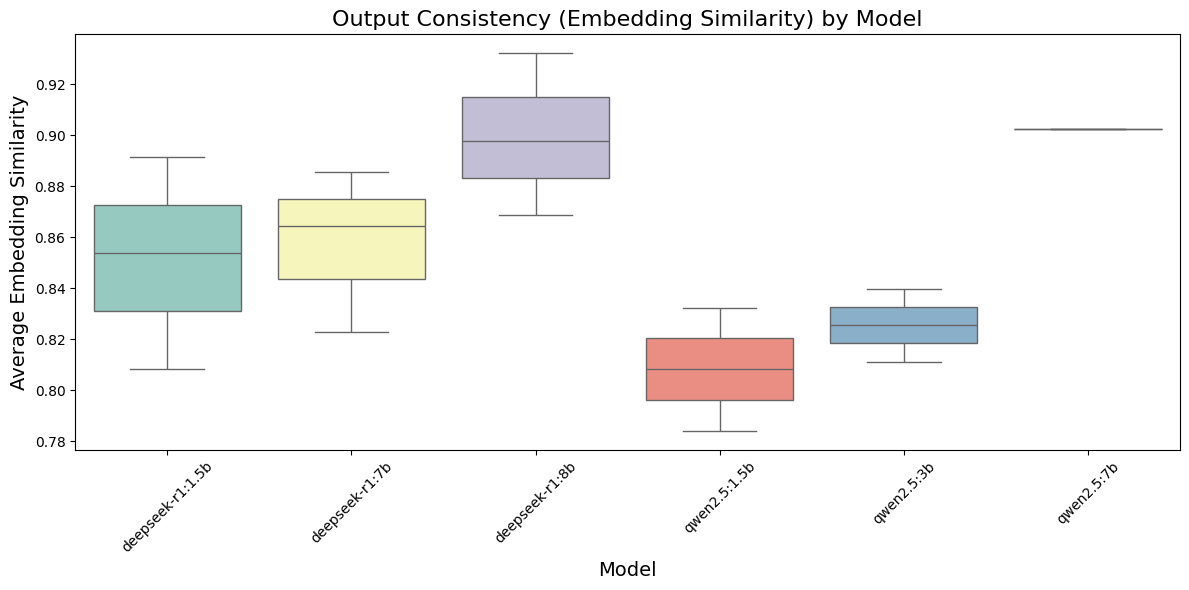

In [149]:
# Create a correlation matrix between embedding similarity and other metrics
if 'embed_results_df' in locals() and not embed_results_df.empty:
    plt.figure(figsize=(10, 8))
    corr_metrics = embed_results_df[['average_inference_time', 'accuracy_rate', 'avg_embedding_similarity']]
    corr_matrix = corr_metrics.corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5)
    plt.title("Correlation Between Metrics", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Visualize embedding similarity by model
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=embed_results_df, x="model", y="avg_embedding_similarity", palette="Set3")
    plt.title("Output Consistency (Embedding Similarity) by Model", fontsize=16)
    plt.xlabel("Model", fontsize=14)
    plt.ylabel("Average Embedding Similarity", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [150]:
# 7.5 Interactive Visualization with Plotly
# Create an interactive scatter plot of inference time vs accuracy with token count as size
fig = px.scatter(summary_df, x="avg_inference_time", y="accuracy_rate", 
                 size="avg_token_count", color="model_name",
                 hover_name="base_question", 
                 hover_data=["sample_count", "avg_tps"],
                 labels={
                     "avg_inference_time": "Average Inference Time (s)",
                     "accuracy_rate": "Accuracy Rate (%)",
                     "avg_token_count": "Average Token Count",
                     "model_name": "Model"
                 },
                 title="Model Performance: Inference Time vs Accuracy vs Token Count")

fig.update_layout(
    width=900,
    height=600,
    xaxis=dict(title=dict(font=dict(size=14))),
    yaxis=dict(title=dict(font=dict(size=14))),
    legend=dict(title=dict(font=dict(size=14))),
    title=dict(font=dict(size=18))
)

fig.show()

In [151]:
# 7.6 Comprehensive Statistical Analysis
# Create a function to generate detailed statistics for each model
def generate_model_stats(df, model_name):
    model_data = df[df["model_name"] == model_name]
    
    stats = {
        "Total Samples": len(model_data),
        "Overall Accuracy (%)": round(model_data["isCorrect"].mean() * 100, 2),
        "Avg Inference Time (s)": round(model_data["average_inference_time"].mean(), 3),
        "Avg Token Count": round(model_data["average_token_count"].mean(), 1),
        "Avg Tokens Per Second": round(model_data["average_tps"].mean(), 1),
        "Best Question Type": model_data.groupby("base_question")["isCorrect"].mean().idxmax(),
        "Best Question Accuracy (%)": round(model_data.groupby("base_question")["isCorrect"].mean().max() * 100, 2),
        "Worst Question Type": model_data.groupby("base_question")["isCorrect"].mean().idxmin(),
        "Worst Question Accuracy (%)": round(model_data.groupby("base_question")["isCorrect"].mean().min() * 100, 2),
        "Best Prompt Type": model_data.groupby("prompt_type")["isCorrect"].mean().idxmax(),
        "Best Prompt Accuracy (%)": round(model_data.groupby("prompt_type")["isCorrect"].mean().max() * 100, 2)
    }
    
    return pd.Series(stats)

# Generate comprehensive stats for all models
model_stats = pd.DataFrame({model: generate_model_stats(df, model) for model in unique_models})
display(model_stats.T)  # Transpose for better readability

ValueError: attempt to get argmax of an empty sequence

/var/folders/8p/3y0vt8nx0j77_stq2p7d95t80000gn/T/ipykernel_18241/1176941919.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




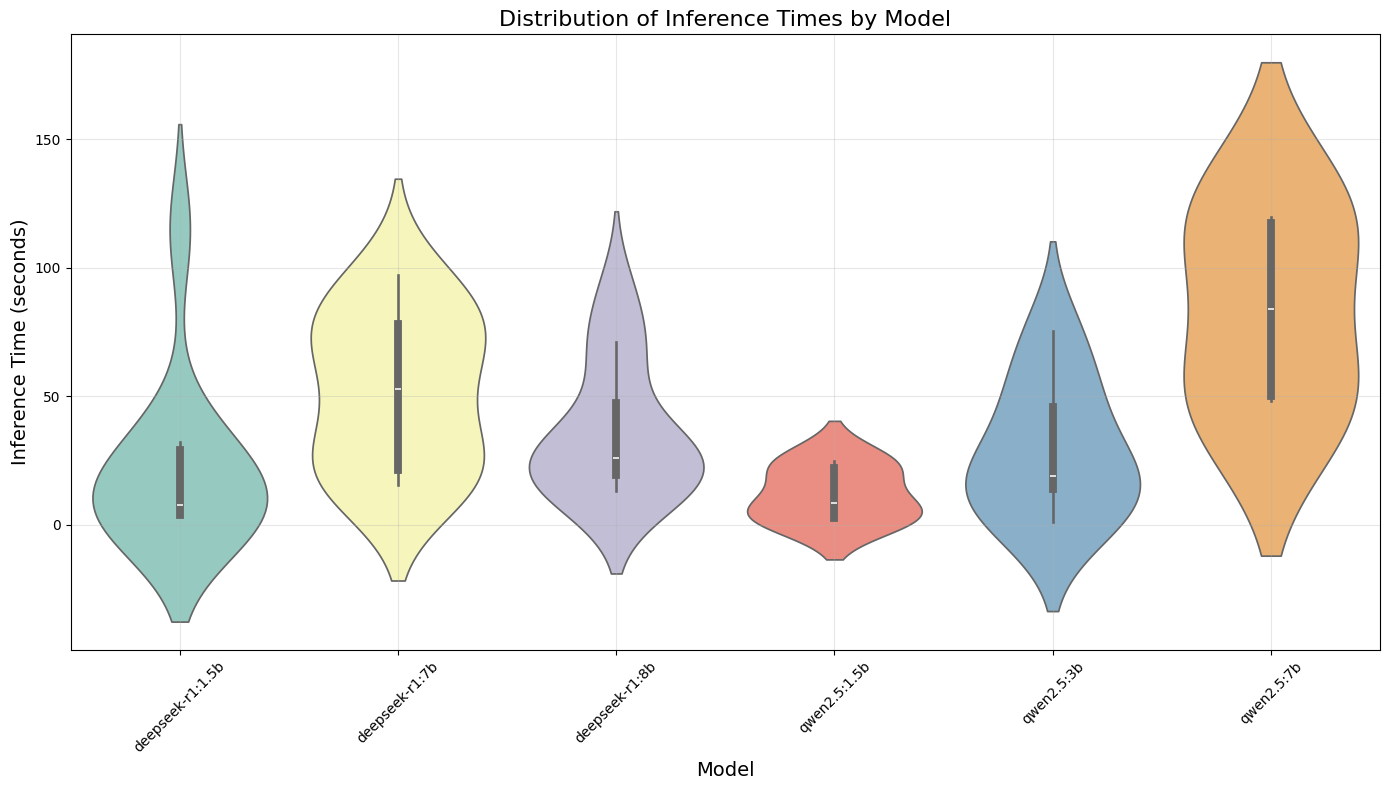

/Users/shehab/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:854: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/Users/shehab/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/Users/shehab/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:854: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/Users/shehab/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/Users/shehab/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:854: FutureWarning:



The `ci

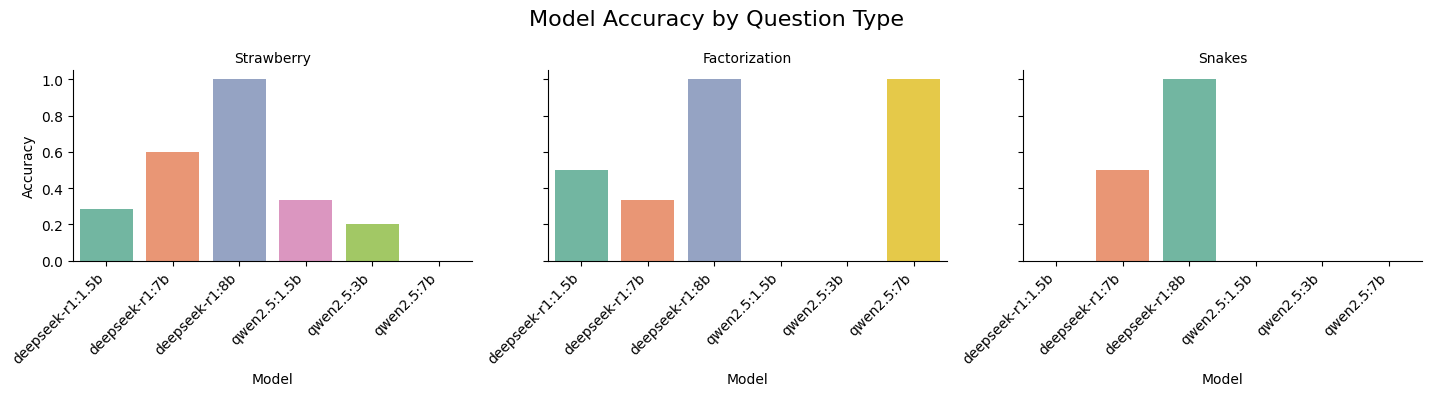

In [ ]:
# 7.7 Performance Distribution Analysis
# Create violin plots to show the distribution of inference times
plt.figure(figsize=(14, 8))
sns.violinplot(data=df, x="model_name", y="average_inference_time", palette="Set3")
plt.title("Distribution of Inference Times by Model", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Inference Time (seconds)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a facet grid to show accuracy distribution by question type and model
g = sns.FacetGrid(df, col="base_question", height=4, aspect=1.2)
g.map_dataframe(sns.barplot, x="model_name", y="isCorrect", ci=None, palette="Set2")
g.set_axis_labels("Model", "Accuracy")
g.set_titles(col_template="{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Model Accuracy by Question Type", fontsize=16)
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

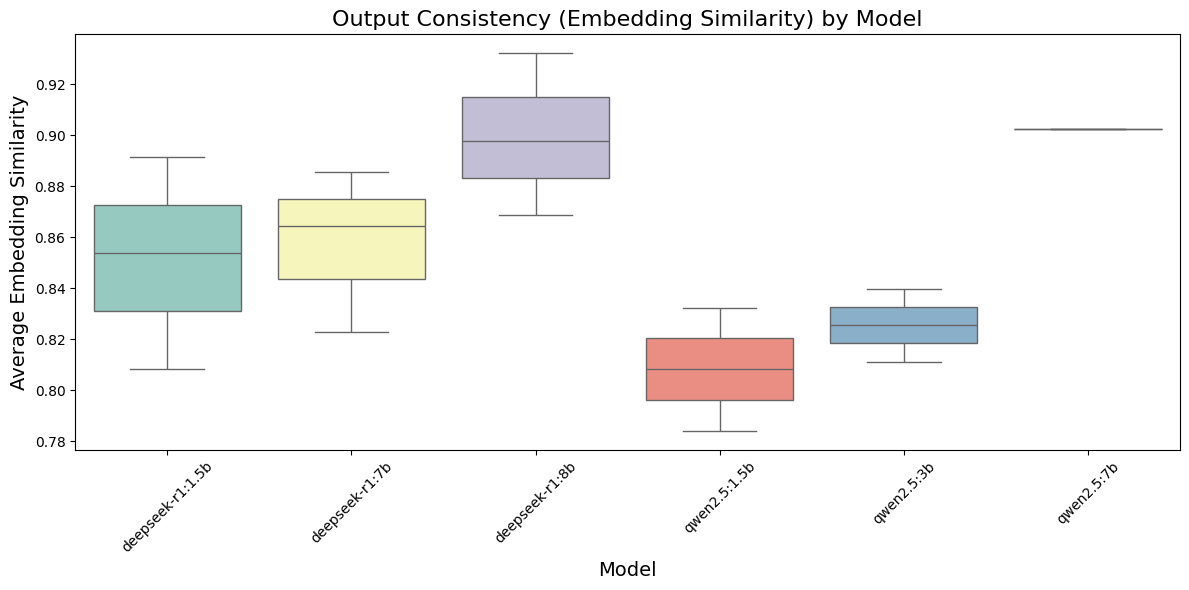

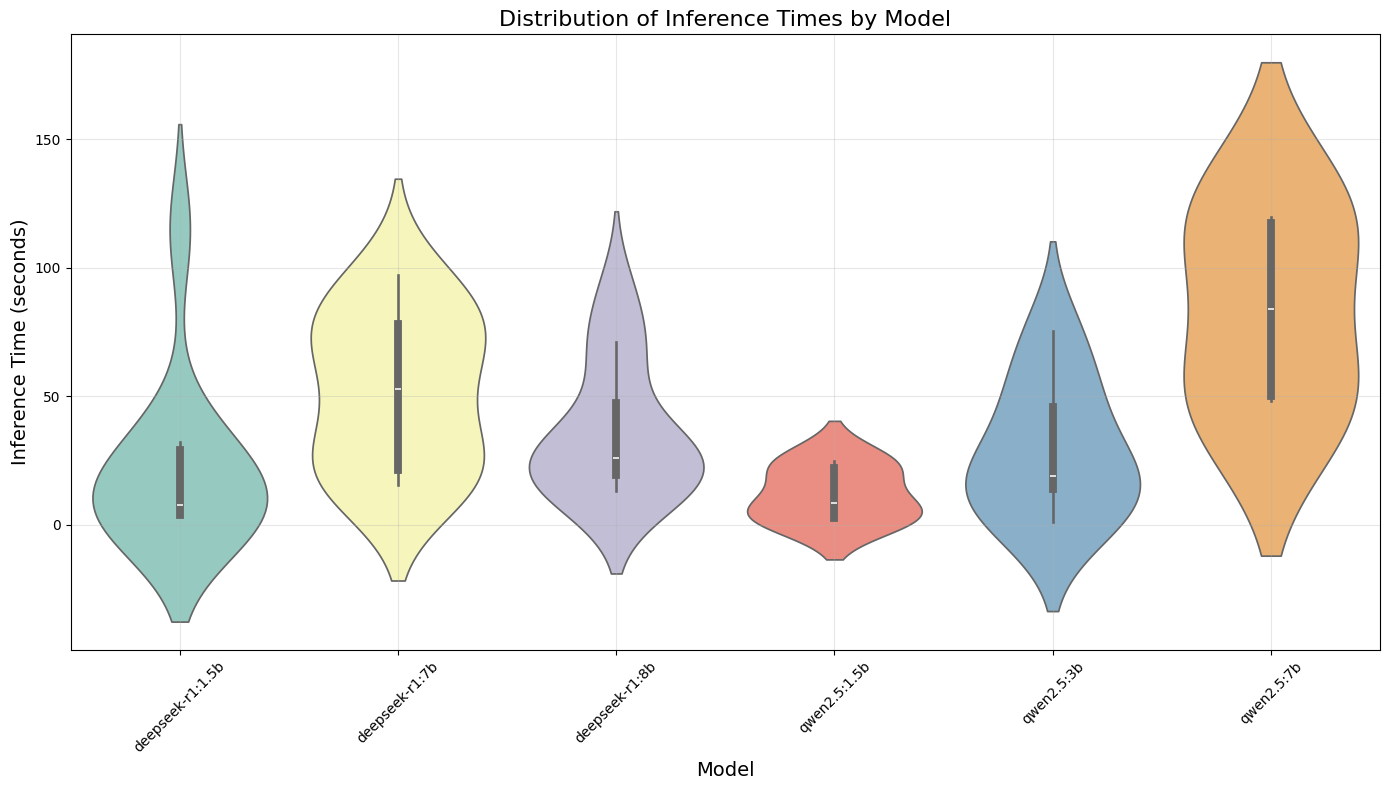

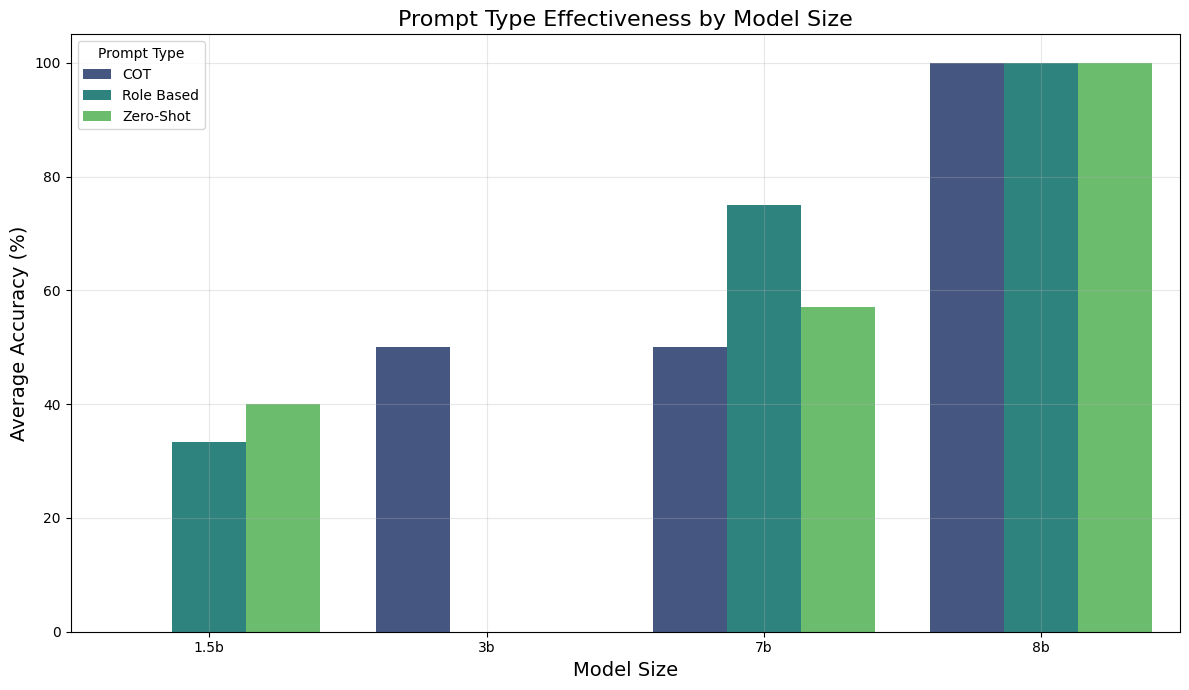

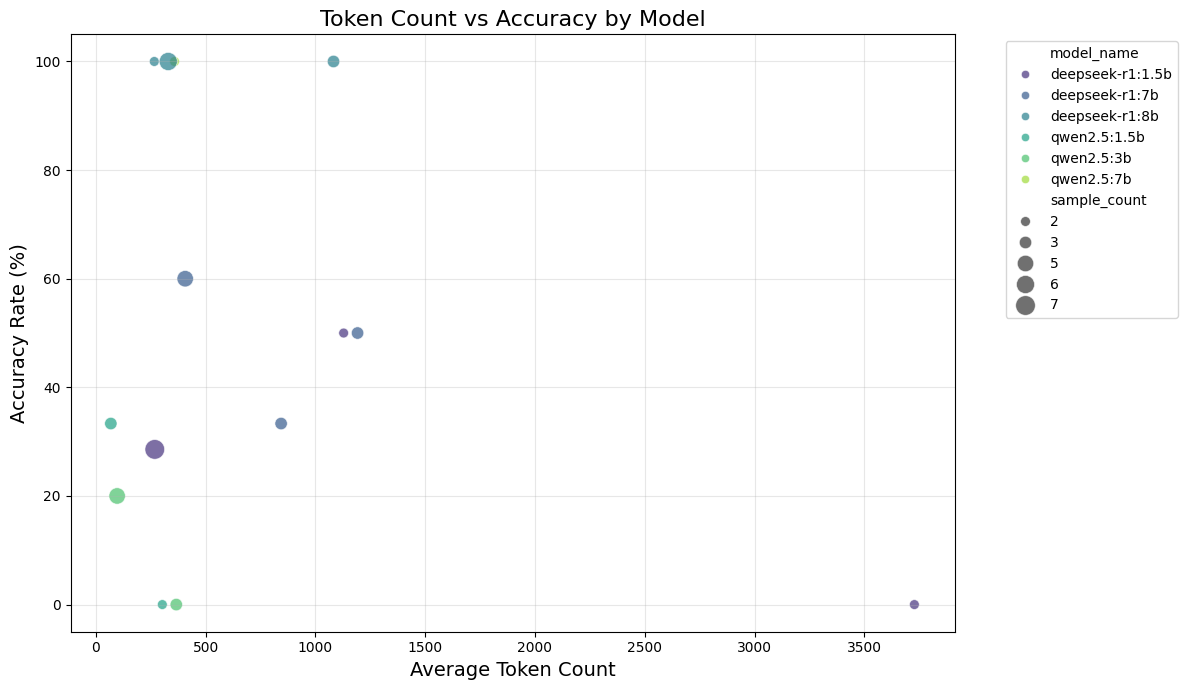

/var/folders/8p/3y0vt8nx0j77_stq2p7d95t80000gn/T/ipykernel_18241/3914239131.py:67: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




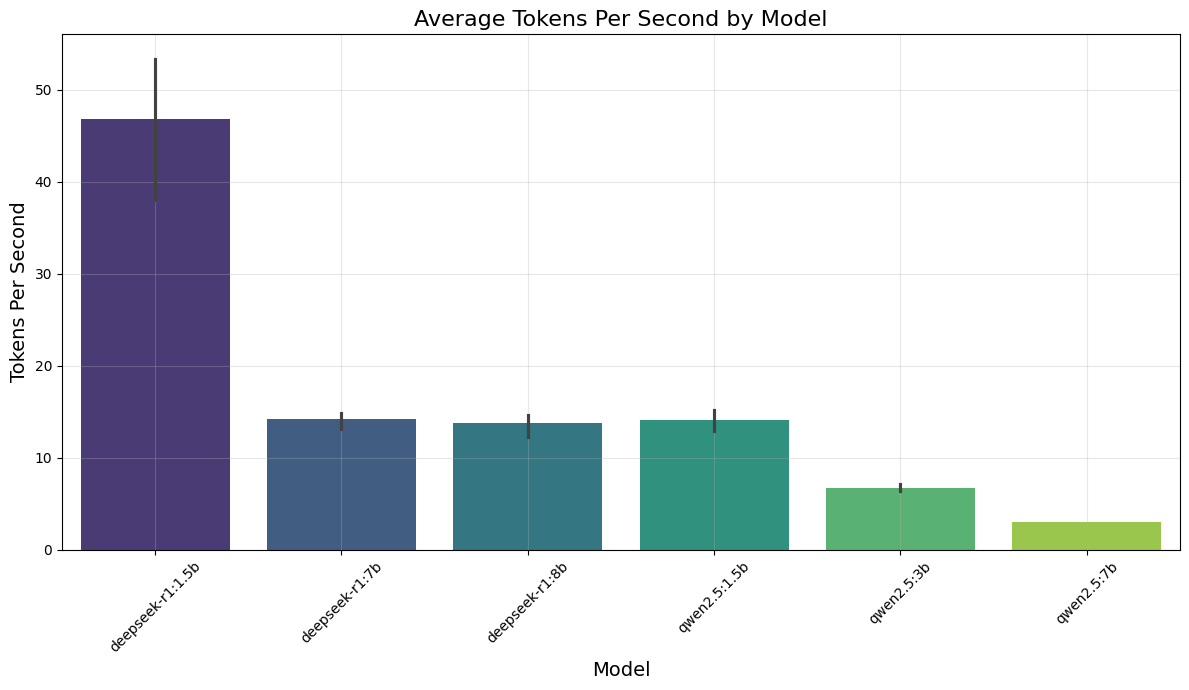

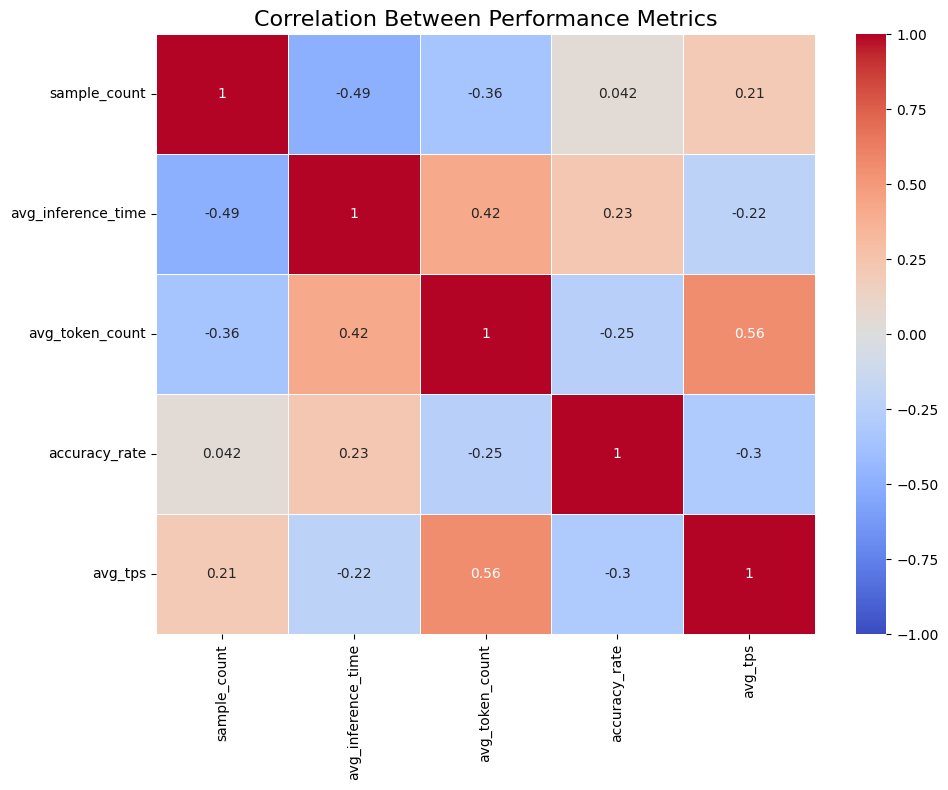

In [135]:
# 8. Advanced Analysis and Visualizations

# 8.1 Fix the Seaborn warnings by updating the boxplot with explicit hue parameter
plt.figure(figsize=(12, 6))
# Create a copy of the dataframe with model as both x and hue
plot_df = embed_results_df.copy()
sns.boxplot(data=plot_df, x="model", y="avg_embedding_similarity", hue="model", palette="Set3", legend=False)
plt.title("Output Consistency (Embedding Similarity) by Model", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Average Embedding Similarity", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 8.2 Fix the violin plot warning
plt.figure(figsize=(14, 8))
# Create a copy with model as both x and hue
plot_df = df.copy()
sns.violinplot(data=plot_df, x="model_name", y="average_inference_time", hue="model_name", palette="Set3", legend=False)
plt.title("Distribution of Inference Times by Model", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Inference Time (seconds)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8.3 Prompt Type Effectiveness by Model Size
# Extract model size from model name (assuming format like "model:size")
df['model_size'] = df['model_name'].str.extract(r':(\d+\.?\d*[b])')

# Group by model size and prompt type
size_prompt_grouped = df.groupby(['model_size', 'prompt_type']).agg(
    count=('prompt_id', 'count'),
    avg_accuracy=('isCorrect', 'mean'),
    avg_inference_time=('average_inference_time', 'mean')
).reset_index()

# Convert to percentage
size_prompt_grouped['avg_accuracy'] = size_prompt_grouped['avg_accuracy'] * 100

plt.figure(figsize=(12, 7))
sns.barplot(data=size_prompt_grouped, x='model_size', y='avg_accuracy', hue='prompt_type', palette='viridis')
plt.title('Prompt Type Effectiveness by Model Size', fontsize=16)
plt.xlabel('Model Size', fontsize=14)
plt.ylabel('Average Accuracy (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Prompt Type')
plt.tight_layout()
plt.show()

# 8.4 Accuracy vs Token Count Analysis
plt.figure(figsize=(12, 7))
sns.scatterplot(data=summary_df, x='avg_token_count', y='accuracy_rate', 
                hue='model_name', size='sample_count', sizes=(50, 200),
                alpha=0.7, palette='viridis')
plt.title('Token Count vs Accuracy by Model', fontsize=16)
plt.xlabel('Average Token Count', fontsize=14)
plt.ylabel('Accuracy Rate (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 8.5 Tokens Per Second Analysis
plt.figure(figsize=(12, 7))
sns.barplot(data=summary_df, x='model_name', y='avg_tps', palette='viridis')
plt.title('Average Tokens Per Second by Model', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Tokens Per Second', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8.6 Correlation Heatmap of All Numeric Metrics
# Select only numeric columns for correlation
numeric_cols = summary_df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = summary_df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)
plt.title('Correlation Between Performance Metrics', fontsize=16)
plt.tight_layout()
plt.show()

# 8.7 Interactive 3D Scatter Plot with Plotly
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=summary_df['avg_inference_time'],
    y=summary_df['avg_token_count'],
    z=summary_df['accuracy_rate'],
    mode='markers',
    marker=dict(
        size=summary_df['sample_count']*3,
        color=summary_df['avg_tps'],
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title="Tokens Per Second")
    ),
    text=summary_df['model_name'] + '<br>Question: ' + summary_df['base_question'],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Analysis: Inference Time vs Token Count vs Accuracy',
    scene=dict(
        xaxis_title='Inference Time (s)',
        yaxis_title='Token Count',
        zaxis_title='Accuracy (%)'
    ),
    width=900,
    height=700
)

fig.show()